In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.st_resnet_models import STResNet, STResNetExtra
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from utils.mock_data import mock_fnn_data_classification
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape
from models.model_result import save_metrics

In [2]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T1H-X1700M-Y1760M"  # needs to exist
model_name = "ST-RESNET"  # needs to be created
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-10-30T20:05:44 | root | INFO | =====================================BEGIN=====================================
2019-10-30T20:05:44 | root | INFO | Device: cpu


### Training loop

In [3]:
# fix normal one first then add the extras
def train_epoch_for_st_res_net_extra(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    """
    Training the STResNetExtra model for a single epoch
    """
    epoch_losses = []
    num_batches = batch_loader.num_batches
    
    demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
    street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)

    for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
        current_batch = batch_loader.current_batch

        batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
        batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
        batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
        batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
        batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

        batch_pred = model(seq_c=batch_seq_c,
                           seq_p=batch_seq_p,
                           seq_q=batch_seq_q,
                           seq_e=batch_seq_e,
                           seq_demog=demog_grid,
                           seq_gsv=street_grid)
        
        # might need to flatten
        loss = loss_fn(input=batch_pred, target=batch_seq_t)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])
        
        if model.training:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
    mean_epoch_loss = np.mean(epoch_losses)
    
    return mean_epoch_loss


def train_epoch_for_st_res_net(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    """
    Training the STResNet model for a single epoch
    """
    c = 0
    epoch_losses = []
    num_batches = batch_loader.num_batches
    
    for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
        current_batch = batch_loader.current_batch

        batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
        batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
        batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
        batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
        batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

        batch_pred = model(seq_c=batch_seq_c,
                           seq_p=batch_seq_p,
                           seq_q=batch_seq_q,
                           seq_e=batch_seq_e)
        
        # might need to flatten
        loss = loss_fn(input=batch_pred, target=batch_seq_t)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])
        
        if model.training:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
        c += 1
        if c > 100:
            break
    mean_epoch_loss = np.mean(epoch_losses)
    
    return mean_epoch_loss

In [4]:
# SET THE HYPER PARAMETERS
conf.early_stopping = False
conf.max_epochs = 4
conf.dropout = 0 #1e-3
conf.weight_decay = 0
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 1e-2
conf.batch_size = 32

# MOCK = False

# CRIME DATA
data_group = GridDataGroup(data_path=data_path, conf=conf)
loaders = GridDataLoaders(data_group=data_group, conf=conf)

2019-10-30T20:05:44 | root | INFO | Data shapes of files in generated_data.npz
2019-10-30T20:05:44 | root | INFO | 	crime_feature_indices shape (10,)
2019-10-30T20:05:46 | root | INFO | 	crime_types_grids shape (17520, 10, 24, 16)
2019-10-30T20:05:46 | root | INFO | 	crime_grids shape (17520, 1, 24, 16)
2019-10-30T20:05:46 | root | INFO | 	tract_count_grids shape (17520, 1, 24, 16)
2019-10-30T20:05:46 | root | INFO | 	demog_grid shape (1, 37, 24, 16)
2019-10-30T20:05:46 | root | INFO | 	street_grid shape (1, 512, 24, 16)
2019-10-30T20:05:46 | root | INFO | 	time_vectors shape (17521, 66)
2019-10-30T20:05:46 | root | INFO | 	weather_vectors shape (8760, 11)
2019-10-30T20:05:46 | root | INFO | 	x_range shape (16,)
2019-10-30T20:05:46 | root | INFO | 	y_range shape (24,)
2019-10-30T20:05:46 | root | INFO | 	t_range shape (17521,)


2019-10-30T20:05:47 | root | INFO | Start Training ST-RESNET
2019-10-30T20:05:47 | root | INFO | Using optimiser: 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


2019-10-30T20:05:47 | root | INFO | Epoch: 0001/0004
2019-10-30T20:05:55 | root | INFO | 	Loss (Trn): 	0.01451
2019-10-30T20:05:55 | root | INFO | 	Loss (Val): 	0.00894
2019-10-30T20:05:55 | root | INFO | 	Loss (Dif): 	0.00558

2019-10-30T20:05:55 | root | INFO | Epoch: 0002/0004
2019-10-30T20:06:02 | root | INFO | 	Loss (Trn): 	0.00945
2019-10-30T20:06:02 | root | INFO | 	Loss (Val): 	0.00890
2019-10-30T20:06:02 | root | INFO | 	Loss (Dif): 	0.00056

2019-10-30T20:06:02 | root | INFO | Epoch: 0003/0004
2019-10-30T20:06:09 | root | INFO | 	Loss (Trn): 	0.00944
2019-10-30T20:06:09 | root | INFO | 	Loss (Val): 	0.00886
2019-10-30T20:06:09 | root | INFO | 	Loss (Dif): 	0.00058

2019-10-30T20:06:09 | root | INFO | Epoch: 0004/0004
2019-10-30T20:06:17 | root |

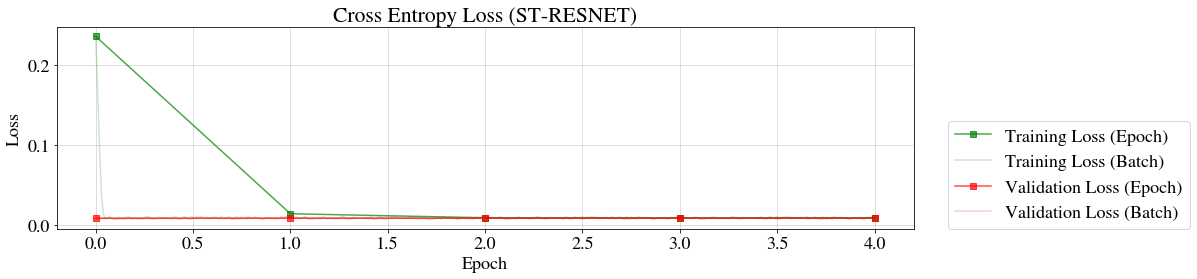

In [5]:
conf.resume = False
conf.freqstr = data_group.t_range.freqstr    

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.MSELoss()  

# SETUP MODEL
dataset = loaders.train_loader.dataset
_, h_size, w_size = dataset.crimes.shape
_, n_ext_features = dataset.time_vectors.shape

USE_EXTRA = True
if USE_EXTRA:
    train_epoch_fn = train_epoch_for_st_res_net
    model = STResNetExtra(n_layers=3,
                          n_channels=1,
                          y_size=h_size,
                          x_size=w_size,

                          lc=dataset.n_steps_c,
                          lp=dataset.n_steps_p,
                          lq=dataset.n_steps_q,

                          n_ext_features=n_ext_features,
                          n_demog_features=37,
                          n_demog_channels=10,
                          n_demog_layers=3,

                          n_gsv_features=512,
                          n_gsv_channels=10,
                          n_gsv_layers=3)
else:
    train_epoch_fn = train_epoch_for_st_res_net
    model = STResNet(n_layers=3,
                     n_channels=1,
                     y_size=h_size,
                     x_size=w_size,

                     lc=dataset.n_steps_c,
                     lp=dataset.n_steps_p,
                     lq=dataset.n_steps_q,

                     n_ext_features=n_ext_features)    
    
# todo implement model_arch for res-net
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()
# todo (optional): setup model parameters dynamically 

optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

if conf.resume:
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

#         # new optimiser hyper-parameters
#         optimiser.param_groups[0]['lr'] = conf.lr
#         optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

best_val_loss, stopped_early = train_model(model=model,
                                            optimiser=optimiser,
                                            loaders=loaders,
                                            train_epoch_fn=train_epoch_fn,
                                            loss_fn=loss_function,
                                            conf=conf)    

print(f"best_val_loss: {best_val_loss}, stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

### Evaluation Code

In [7]:
from utils.metrics import best_threshold

In [7]:

# FIX NORMAL ONE FIRST THEN ADD THE EXTRAS
def evaluate_st_res_net_extra(model, batch_loader, conf):  
    """
    Only used to get probas in a time and location based format. The hard predictions should be done outside 
    this function where the threshold is determined using only the training data
    """
    
    probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)    
    y_counts = batch_loader.dataset.targets[-len(probas_pred):]
    y_true = np.copy(y_counts)
    y_true[y_true > 0] = 1

    
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]
    
    with torch.set_grad_enabled(False):
        model.eval()
            
        num_batches = batch_loader.num_batches
        
        demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
        street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)
        
        for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
            current_batch = batch_loader.current_batch
            
            batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
            batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
            batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
            batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
            batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

            batch_probas_pred = model(seq_c=batch_seq_c,
                                      seq_p=batch_seq_p,
                                      seq_q=batch_seq_q,
                                      seq_e=batch_seq_e,
                                      seq_demog=demog_grid,
                                      seq_gsv=street_grid)
                
            for i,p in zip(batch_indices, batch_probas_pred):
                probas_pred[i] = p
                
    
    return y_counts, y_true, probas_pred, t_range

def evaluate_st_res_net(model, batch_loader, conf):    
    """
    Only used to get probas in a time and location based format. The hard predictions should be done outside 
    this function where the threshold is determined using only the training data
    """
    
    probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)    
    y_counts = batch_loader.dataset.targets[-len(probas_pred):]
    y_true = np.copy(y_counts)
    y_true[y_true > 0] = 1
    
    
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]
    
    with torch.set_grad_enabled(False):
        model.eval()
            
        num_batches = batch_loader.num_batches
        
        demog_grid = torch.Tensor(batch_loader.dataset.demog_grid).to(conf.device)
        street_grid = torch.Tensor(batch_loader.dataset.street_grid).to(conf.device)
        
        for batch_indices, batch_seq_c, batch_seq_p, batch_seq_q, batch_seq_e, batch_seq_t in batch_loader:
            current_batch = batch_loader.current_batch

            batch_seq_c = torch.Tensor(batch_seq_c).to(conf.device)
            batch_seq_p = torch.Tensor(batch_seq_p).to(conf.device)
            batch_seq_q = torch.Tensor(batch_seq_q).to(conf.device)
            batch_seq_e = torch.Tensor(batch_seq_e).to(conf.device)
            batch_seq_t = torch.Tensor(batch_seq_t).to(conf.device)

            batch_probas_pred = model(seq_c=batch_seq_c,
                                      seq_p=batch_seq_p,
                                      seq_q=batch_seq_q,
                                      seq_e=batch_seq_e)                
                
            for i,p in zip(batch_indices, batch_probas_pred.numpy()):
                probas_pred[i] = p           

    
    return y_counts, y_true, probas_pred, t_range

In [8]:
# this is the issue - y_true is continuous and should be 1 or 0
# when training y_true is actual count and  

In [10]:
from utils.metrics import best_threshold
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, PerTimeStepPlotter

2019-10-29T20:37:51 | root | INFO | f1_score: 0.22885357769234574 at index 1855333, new threshold 2.1828467922091477e-08
2019-10-29T20:37:56 | root | INFO | f1_score: 0.2181650530198248 at index 1268858, new threshold 7.652405820124386e-09
probas_pred


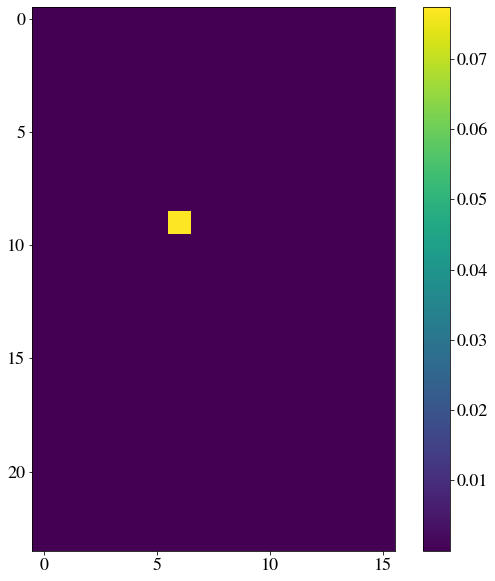

y_true


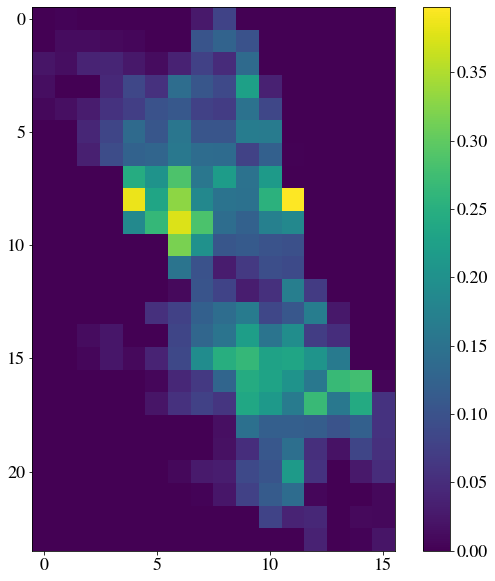

y_pred


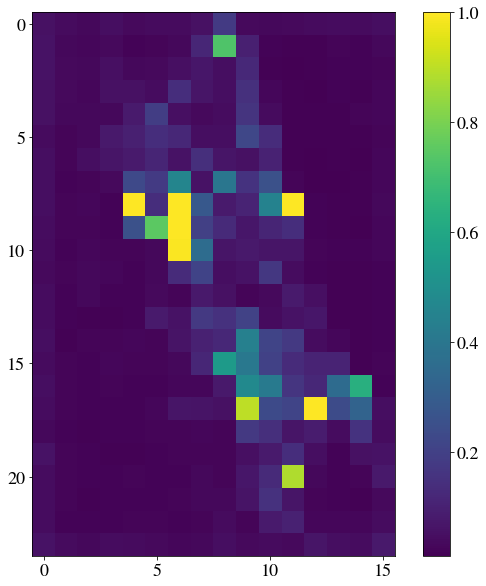

y_counts


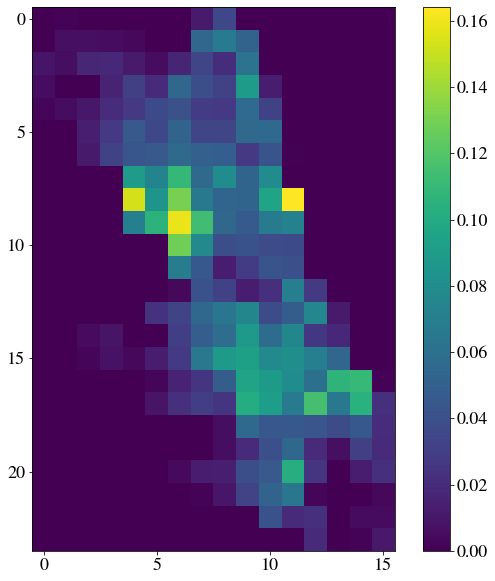

In [11]:
trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_st_res_net_extra(model=model,
                                                                           batch_loader=loaders.train_loader,
                                                                           conf=conf) 

thresh = best_threshold(trn_y_true, trn_probas_pred) 

y_counts, y_true, probas_pred, t_range = evaluate_st_res_net(model=model,
                                                           batch_loader=loaders.test_loader,
                                                           conf=conf)


y_pred = get_y_pred(thresh, probas_pred)

print("probas_pred")
im(probas_pred.mean(0))
print("y_true")
im(y_true.mean(0))
print("y_pred")
im(y_pred.mean(0))
print("y_counts")
im(y_counts.mean(0))

y_counts=data_group.shaper.squeeze(np.expand_dims(y_counts,axis=1))    
y_true=data_group.shaper.squeeze(np.expand_dims(y_true,axis=1))
y_pred=data_group.shaper.squeeze(np.expand_dims(y_pred,axis=1))
probas_pred=data_group.shaper.squeeze(np.expand_dims(probas_pred,axis=1))

setup - done


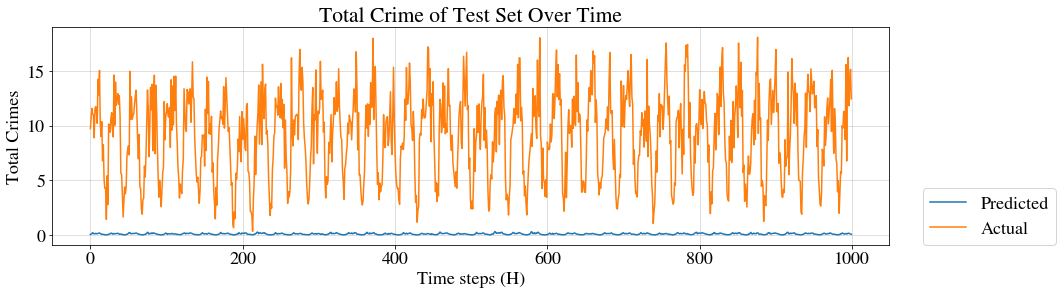

In [14]:
lim = 1000

# should be done on the y_count not y_true    
total_crime_plot = PerTimeStepPlotter(time_step=t_range.freqstr,ylabel="Total Crimes")
total_crime_plot.plot(probas_pred.sum(-1)[:lim,0],label="Predicted")
total_crime_plot.plot(y_counts.sum(-1)[:lim,0],label="Actual")
total_crime_plot.show()

In [ ]:
def save_metrics_resnet(y_counts, y_true, y_pred, probas_pred, t_range, shaper, conf):
    """
    Training the model for a single epoch
    """
    # save result
    # only saves the result of the metrics not the predicted values
    model_metrics = ModelMetrics(model_name=conf.model_name,
                                 y_true=y_true,
                                 y_pred=y_pred,
                                 probas_pred=probas_pred)
    log.info(model_metrics)

    # saves the actual target and predicted values to be visualised later on
    model_result = ModelResult(model_name=conf.model_name,
                               y_true=y_true,
                               y_pred=y_pred,
                               probas_pred=probas_pred,
                               t_range=t_range,
                               shaper=shaper)
    log.info(model_result)

    # do result plotting and saving
    pr_plotter = PRCurvePlotter()
    pr_plotter.add_curve(y_true.flatten(), probas_pred.flatten(), label_name=conf.model_name)
    pr_plotter.savefig(f"{conf.model_path}plot_pr_curve.png")

    roc_plotter = ROCCurvePlotter()
    roc_plotter.add_curve(y_true.flatten(), probas_pred.flatten(), label_name=conf.model_name)
    roc_plotter.savefig(f"{conf.model_path}plot_roc_curve.png")
            
    # should be done on the y_count not y_true    
    total_crime_plot = PerTimeStepPlotter(time_step=t_range.freqstr,ylabel="Total Crimes")
    total_crime_plot.plot(probas_pred.sum(-1)[:100,0],label="Predicted")
    total_crime_plot.plot(y_counts.sum(-1)[:100,0],label="Actual")
    total_crime_plot.savefig(f"{conf.model_path}plot_total_crimes.png")
    
    
    
y_counts, y_true, y_pred, probas_pred, t_range = evaluate_st_res_net(model=model,
                                                           batch_loader=loaders.test_loader,
                                                           conf=conf)    
 

    
y_counts=data_group.shaper.squeeze(np.expand_dims(y_counts,axis=1))    
y_true=data_group.shaper.squeeze(np.expand_dims(y_true,axis=1))
y_pred=data_group.shaper.squeeze(np.expand_dims(y_pred,axis=1))
probas_pred=data_group.shaper.squeeze(np.expand_dims(probas_pred,axis=1))


# need to squeeze values before saving    
save_metrics_resnet(y_counts=y_counts,
                    y_true=y_true,
                    y_pred=y_pred,
                    probas_pred=probas_pred,
                    t_range=t_range,
                    shaper=None,#data_group.shaper,                
                    conf=conf)     

In [ ]:
pshape(y_counts, y_true, probas_pred)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def dist(a):
    v,c = np.unique(a.flatten(),return_counts=True)
    c = c/np.sum(c)
    return v,c

def plot_dist(a):
    plt.bar(*dist(a),alpha=.2)
    

plot_dist(y_counts)  
plot_dist(y_true)
plot_dist(probas_pred)

In [ ]:
save_metrics_resnet(y_counts=y_counts,
                    y_true=y_true,
                    y_pred=y_counts,
                    probas_pred=probas_pred,
                    t_range=t_range,
                    shaper=None,#data_group.shaper,                
                    conf=conf)     

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
v,c = np.unique(y_pred.flatten(), return_counts=True)
c = c/np.sum(c)

plt.bar(v,c)


In [ ]:
y_true, y_pred, probas_pred, t_range = evaluate_st_res_net(model=model,
                                                           batch_loader=loaders.test_loader,
                                                           conf=conf)    

In [ ]:
im(y_true.max(0))